<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read Data</a></span><ul class="toc-item"><li><span><a href="#make-a-sample-diversity-barplot-and-table" data-toc-modified-id="make-a-sample-diversity-barplot-and-table-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>make a sample diversity barplot and table</a></span><ul class="toc-item"><li><span><a href="#bar-plot" data-toc-modified-id="bar-plot-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>bar plot</a></span></li><li><span><a href="#OTU-table" data-toc-modified-id="OTU-table-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>OTU table</a></span></li></ul></li><li><span><a href="#OTU-hist" data-toc-modified-id="OTU-hist-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>OTU hist</a></span></li></ul></li><li><span><a href="#Calculate-Alpha-Diversity" data-toc-modified-id="Calculate-Alpha-Diversity-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate Alpha Diversity</a></span><ul class="toc-item"><li><span><a href="#Faith-PD" data-toc-modified-id="Faith-PD-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><strong>Faith PD</strong></a></span><ul class="toc-item"><li><span><a href="#Permanovas" data-toc-modified-id="Permanovas-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Permanovas</a></span></li></ul></li></ul></li><li><span><a href="#Major-phylogroup-diversity" data-toc-modified-id="Major-phylogroup-diversity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Major phylogroup diversity</a></span><ul class="toc-item"><li><span><a href="#centroid-sample" data-toc-modified-id="centroid-sample-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>centroid sample</a></span></li></ul></li><li><span><a href="#All-PERMANOVAs" data-toc-modified-id="All-PERMANOVAs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>All PERMANOVAs</a></span></li><li><span><a href="#ADONIS" data-toc-modified-id="ADONIS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>ADONIS</a></span></li></ul></div>

**Basic Diversity**

In [1]:
import os, scipy
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
import seaborn as sns
from qiime2 import Artifact
from qiime2.plugins.diversity.pipelines import alpha_phylogenetic
from qiime2.plugins import feature_table,phylogeny
from skbio.stats.distance import permanova, DistanceMatrix
from skbio.stats.ordination import pcoa
from qiime2.plugins.taxa.methods import collapse
datapath = '../Data'

# Read Data

In [2]:
# metadata
bombusMeta = pd.read_csv(os.path.join(datapath,'meta/bombusMeta.csv'))
bombusMeta.set_index('id', inplace = True)
bombusMeta['caste'] = bombusMeta['caste'].replace('M ', 'M')
bombusMeta['Year'] = bombusMeta['Year'].astype('str')
bombusMeta['days_Since_May1']=bombusMeta['date_of_collection'].apply(lambda x: (pd.to_datetime(x) - 
                                                pd.to_datetime('5/1/' +str(pd.to_datetime(x).year) )).days)
# Feature Table
mt_99 = Artifact.load(os.path.join(datapath, 'qiime', 'mt_99.qza'))
mt_99_rare = Artifact.load(os.path.join(datapath, 'qiime', 'mt_99_rare.qza'))
#Tree
rooted_tree_99=Artifact.load(os.path.join(datapath, 'qiime/rooted_tree_99.qza'))

#Taxa
taxa_99 = Artifact.load(os.path.join(datapath, 'qiime', 'taxonomy_99.qza')).view(pd.DataFrame)

# distance mats
wu_df = pd.read_csv(os.path.join(datapath, 'dm/wudf.csv'), index_col=0)
uu_df = pd.read_csv(os.path.join(datapath, 'dm/uudf.csv'), index_col=0)

In [9]:
bombusMeta['species'].replace({'fer':'bor'},
                             inplace = True)

## make a sample diversity barplot and table 

### bar plot 

In [10]:
plotdf = bombusMeta[['species', 'caste', 'Year']].copy()
plotdf['count'] = plotdf['species'] + '-' +plotdf['caste'] +'-'+plotdf['Year']
plotdf = pd.DataFrame(plotdf['count'].value_counts())
plotdf['species'] = plotdf.index
plotdf['caste'] = plotdf['species'].apply(lambda x: x.split('-')[1])
plotdf['Year'] =plotdf['species'].apply(lambda x: x.split('-')[2])
plotdf['species'] =plotdf['species'].apply(lambda x: x.split('-')[0])
                                          

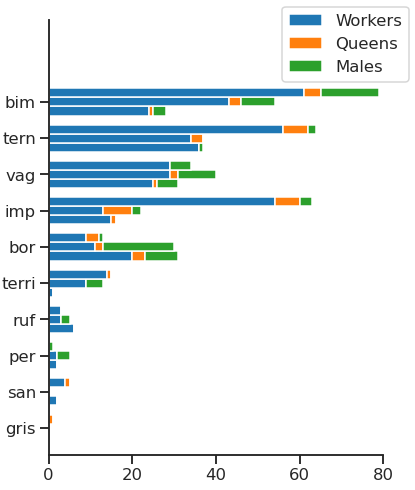

In [11]:
# y axis: species and year
# x axis: blocks by caste 
data_dict = {'2017': {'W': [],
                     'M': [],
                     'Q': []},
            '2018': {'W': [],
                     'M': [],
                     'Q': []},
            '2019': {'W': [],
                     'M': [],
                     'Q': []}}

species = plotdf.groupby('species')['count'].sum().sort_values(ascending = True).index.to_list()
for s in species:
    for year in ['2017', '2018', '2019']:
        for caste in ['W', 'M', 'Q']:
            if s+'-'+caste+'-'+year in plotdf.index:
                data_dict[year][caste].append(plotdf.loc[s+'-'+caste+'-'+year, 'count'])
            else: data_dict[year][caste].append(0)
                    

                
with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")   
    fig, ax = plt.subplots(figsize = (6, 8))

    # plot details
    bar_width = 0.25
    epsilon = .015
    line_width = 1
    opacity = 0.7
    s17_bar_positions = np.arange(len(species))
    s18_bar_positions = s17_bar_positions + bar_width
    s19_bar_positions = s18_bar_positions + bar_width
    
    s17_worker_bars = plt.barh( s17_bar_positions, data_dict['2017']['W'], bar_width,
                              color='C0')
    s17_queen_bars = plt.barh(s17_bar_positions, data_dict['2017']['Q'], bar_width,
                              left=data_dict['2017']['W'],
                              color='C1')
    s17_male_bars = plt.barh(s17_bar_positions, data_dict['2017']['M'], bar_width,
                              left=np.array(data_dict['2017']['W']) + np.array(data_dict['2017']['Q']),
                              color='C2')
    
    s18_worker_bars = plt.barh( s18_bar_positions, data_dict['2018']['W'], bar_width,
                              color='C0')
    s18_queen_bars = plt.barh(s18_bar_positions, data_dict['2018']['Q'], bar_width,
                              left=data_dict['2018']['W'],
                              color='C1')
    s18_male_bars = plt.barh(s18_bar_positions, data_dict['2018']['M'], bar_width,
                              left=np.array(data_dict['2018']['W']) + np.array(data_dict['2018']['Q']),
                              color='C2')
    
    s19_worker_bars = plt.barh( s19_bar_positions, data_dict['2019']['W'], bar_width,
                              color='C0',
                              label='Workers')
    s19_queen_bars = plt.barh(s19_bar_positions, data_dict['2019']['Q'], bar_width,
                              left=data_dict['2019']['W'],
                              color='C1',
                              label='Queens')
    s19_male_bars = plt.barh(s19_bar_positions, data_dict['2019']['M'], bar_width,
                              left=np.array(data_dict['2019']['W']) + np.array(data_dict['2019']['Q']),
                              color='C2',
                              label='Males')
    plt.xlim(0,80)
    plt.ylim(-.5,11.5)
    
    plt.yticks(s18_bar_positions, species, rotation=0)
    plt.legend(bbox_to_anchor=(1.1, 1.05)) 
    sns.despine()
    #plt.show()
    plt.savefig('figs/species_counts_per_year.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

Look for temporal blooms 

species with high relative abundance at one point in the summer? Not sure how to do this

### OTU table

In [184]:
core_prev_counts = bombusMeta[['species', 'caste']].join(level6[[x for\
                x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])]].rename(\
            columns = dict(zip([x for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])],
        [x.split('g__')[1] for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])]))) >0)

In [208]:
temp = core_prev_counts.copy()
temp['caste'] = 'Z'

In [215]:
pd.concat([core_prev_counts, temp]).groupby(['species',
    'caste']).sum().join(pd.concat([core_prev_counts, temp]).groupby(['species',
                    'caste']).mean().apply(lambda x: \
        round(x*100)).rename(columns = dict(zip(core_prev_counts.columns[2:],
            core_prev_counts.columns[2:]+'%'))))[sorted(list(core_prev_counts.columns[2:]) +\
           list(core_prev_counts.columns[2:]+'%'))].to_csv(os.path.join(datapath,
        'table', 'prev_table.tsv'), sep = '\t')

## OTU hist

In [14]:
mt_99 = mt_99.view(pd.DataFrame)
mt_99_rel = (mt_99.transpose()/mt_99.sum(axis=1)).transpose()

In [15]:
(mt_99_rel.apply(lambda x: x> 0.01).sum() > 1).sum()

107

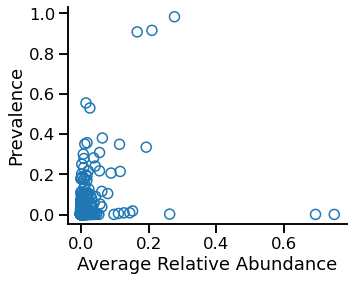

In [16]:
fig, ax = plt.subplots(figsize = (5,4))
plotdf = pd.DataFrame({'Mean':mt_99_rel.replace(0, np.nan).mean(),
              'Prev':(mt_99_rel >0).mean()})
plotdf['clade'] = taxa_99['Taxon'].apply(lambda x: x.split('c__')[1].split(';')[0] if 'c__' in x else \
                x.split('p__')[1].split(';')[0] if 'p__' in x else \
                x.split('d__')[1].split(';')[0] if 'd__' in x else 'other')
plt.scatter(x = plotdf['Mean'], y = plotdf['Prev'],
               facecolors="none", edgecolor = 'C0', s = 100, alpha =1)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Average Relative Abundance')
plt.ylabel('Prevalence')
sns.despine()
plt.savefig('figs/OTU_prev_abund.pdf',
               format = 'pdf', transparent = True, 
           bbox_inches="tight" )

# Calculate Alpha Diversity

## Faith PD

In [3]:
faithpd = alpha_phylogenetic(table = mt_99_rare, phylogeny = rooted_tree_99, metric ='faith_pd')
bombusMeta['faithpd'] = faithpd.alpha_diversity.view(pd.Series)

### Permanovas

In [4]:
permanova(distance_matrix = DistanceMatrix(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(\
                bombusMeta[['faithpd']].dropna()))),
          grouping = bombusMeta[['Year', 'faithpd']].dropna()['Year'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     631
number of groups                  3
test statistic              32.0971
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [5]:
bombusMeta.groupby('Year')['faithpd'].mean()

Year
2017    3.958747
2018    3.894845
2019    2.320604
Name: faithpd, dtype: float64

In [6]:
permanova(distance_matrix = DistanceMatrix(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(\
                bombusMeta[['faithpd']].dropna()))),
          grouping = bombusMeta[['caste', 'faithpd']].dropna()['caste'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     631
number of groups                  3
test statistic              1.90959
p-value                       0.132
number of permutations          999
Name: PERMANOVA results, dtype: object

In [7]:
bombusMeta.groupby('caste')['faithpd'].mean()

caste
M    3.733300
Q    3.013321
W    3.157576
Name: faithpd, dtype: float64

# Major phylogroup diversity

In [4]:
weightedpc = pcoa(wu_df)
bombusMeta = bombusMeta.join(weightedpc.samples[['PC1', 'PC2']].set_index(wu_df.index))

/opt/miniconda3/envs/bombus2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.3371704676803794 and the largest is 9.531799062285977.
  warn(


In [5]:
level3 = collapse(mt_99, taxa_99, 3).collapsed_table.view(pd.DataFrame)
level3 = (level3.transpose() / level3.sum(axis =1)).transpose()

level2 = collapse(mt_99, taxa_99, 2).collapsed_table.view(pd.DataFrame)
level2 = (level2.transpose() / level2.sum(axis =1)).transpose()
level6 = collapse(mt_99, taxa_99, 6).collapsed_table.view(pd.DataFrame)
level6 = (level6.transpose() / level6.sum(axis =1)).transpose()

In [6]:
level2.median().sort_values()[-5:]

d__Bacteria;p__Spirochaetota       0.000000
d__Bacteria;p__Bacteroidota        0.000067
d__Bacteria;p__Firmicutes          0.001572
d__Bacteria;p__Actinobacteriota    0.003380
d__Bacteria;p__Proteobacteria      0.982292
dtype: float64

In [7]:
level3.median().sort_values()[-5:]

d__Bacteria;p__Bacteroidota;c__Bacteroidia              0.000067
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria    0.001526
d__Bacteria;p__Firmicutes;c__Bacilli                    0.001531
d__Bacteria;p__Actinobacteriota;c__Actinobacteria       0.003325
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria    0.944519
dtype: float64

In [8]:
level6.median().sort_values()[-5:]

d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bombiscardovia    0.000184
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas        0.000255
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Candidatus_Schmidhempelia          0.003117
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Gilliamella                        0.075199
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Snodgrassella         0.139929
dtype: float64

check if controlling for trip changes things, it looks like it doesnt! 

In [38]:
bombusMeta['site_trip'] = bombusMeta['site_collapsed'] + bombusMeta['date_of_collection']

In [47]:
site_trip_means = pd.DataFrame(columns = level6.columns)
for s in bombusMeta['site_trip'].unique():
    site_trip_means.loc[s] = level6.loc[bombusMeta[bombusMeta['site_trip'] == s].index].mean()

In [52]:
level6.mean().sort_values().iloc[-8:]

d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Rosenbergiella     0.017707
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;__                                0.018541
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Weeksellaceae;g__Apibacter                  0.027249
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Ochrobactrum           0.040464
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas    0.071094
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Gilliamella                    0.178373
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Candidatus_Schmidhempelia      0.193365
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Snodgrassella     0.271640
dtype: float64

In [51]:
site_trip_means.mean().sort_values().iloc[-8:]

d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas    0.016068
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;__                                     0.017225
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Weeksellaceae;g__Apibacter                       0.045007
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas         0.051472
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Ochrobactrum                0.057148
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Gilliamella                         0.197713
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Candidatus_Schmidhempelia           0.202685
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Snodgrassella          0.257340
dtype: f

make an abundance plot for an eventual figure

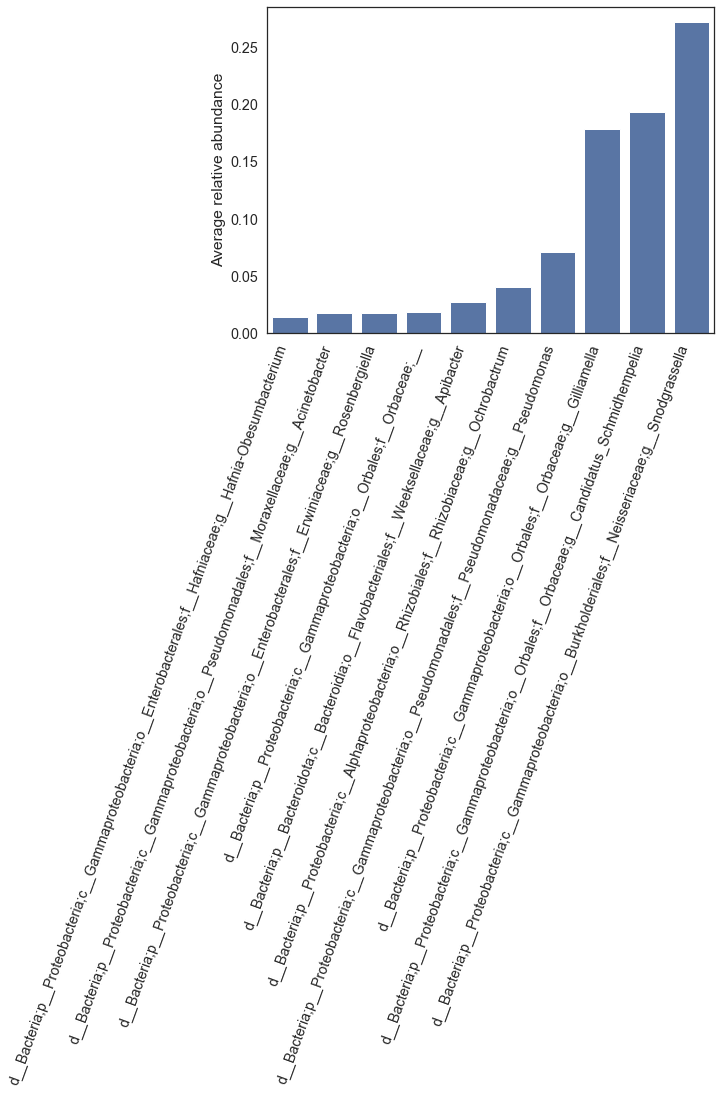

In [178]:
sns.set(font_scale=1.3, style ='white')
fig, ax = plt.subplots(figsize = (8,6))
sns.barplot(x = level6.mean().sort_values()[-10:].index,
            y = level6.mean().sort_values()[-10:], color = 'C0', ax = ax)
plt.xticks(rotation = 70, ha='right')
plt.ylabel('Average relative abundance')
#plt.show()
plt.savefig('figs/avg_ra_top_taxa.pdf', transparent = True)

In [22]:
bombusMeta = bombusMeta.join(level3[['d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria',
                       'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria']].rename(columns = \
    dict(zip(['d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria',
                       'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria'],
            ['Gammaproteobacteria','Alphaproteobacteria' ]))))

bombusMeta = bombusMeta.join(level2[['d__Bacteria;p__Firmicutes']].rename(columns = \
    dict(zip(['d__Bacteria;p__Firmicutes'],
            ['Firmicutes' ]))))

In [23]:
bombusMeta = bombusMeta.join(level6[[x for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])]]).rename(\
            columns = dict(zip([x for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])],
        [x.split('g__')[1] for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])])))

bombusMeta.rename(columns = {'Candidatus_Schmidhempelia': 'Schmidhempelia'}, inplace = True)

In [27]:
bombusMeta['core'] = bombusMeta[['Snodgrassella', 'Gilliamella', 'Lactobacillus',
                        'Bifidobacterium','Bombiscardovia',
           'Schmidhempelia','Apibacter' ]].sum(axis=1)

In [28]:
bombusMeta['Proteobacteria'] = bombusMeta[['Gammaproteobacteria','Alphaproteobacteria' ]].sum(axis=1)

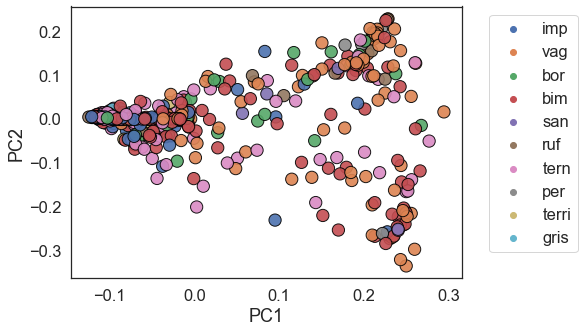

In [18]:
sns.set(style = 'white', font_scale = (1.5))
fig, ax = plt.subplots(1, figsize = (7, 5))

sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            hue = bombusMeta['species'],
                s = 150, alpha = 0.9, ax = ax, edgecolor='black')
#sns.move_legend(ax, loc = 'upper left', bbox_to_anchor = (1.05,1))
plt.legend(bbox_to_anchor = (1.05,1))
plt.savefig('figs/species_pca.pdf', transparent = True, bbox_inches='tight')

In [ ]:
sns.set(style = 'white', font_scale = (1.5))
fig, ax = plt.subplots(1, figsize = (7, 5))

sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            hue = bombusMeta['species'],
                s = 150, alpha = 0.9, ax = ax, edgecolor='black')
sns.move_legend(ax, loc = 'upper left', bbox_to_anchor = (1.05,1))

plt.savefig('figs/species_pca.pdf', transparent = True)

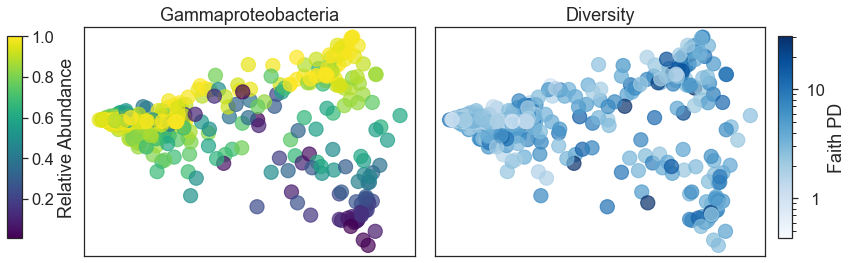

In [19]:
sns.set(style = 'white', font_scale = (1.5))
fig, ax = plt.subplots(1,2, figsize = (10, 4), sharey = True)

sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            c = bombusMeta['Gammaproteobacteria'],
                s = 200, alpha = 0.7, ax = ax[0], edgecolor = None,
               cmap = 'viridis')
p1 = sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            c = bombusMeta['faithpd'].transform(lambda x: np.log(12) if x > 12 else np.log(x)),
                s = 200, alpha = 0.7, ax = ax[1],edgecolor = None, cmap = "Blues")
ax[0].set_title('Gammaproteobacteria')
ax[1].set_title('Diversity')

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_xlabel("")


plt.tight_layout()

ax[0].figure.colorbar(plt.cm.ScalarMappable(norm=colors.Normalize(vmin=bombusMeta['Gammaproteobacteria'].min(),
                      vmax=bombusMeta['Gammaproteobacteria'].max()), cmap='viridis'),
                      cax = fig.add_axes([-0.08, .13, .02, .7]),
                     label = 'Relative Abundance')

cbar1 = ax[1].figure.colorbar(plt.cm.ScalarMappable(norm=colors.LogNorm(vmin=bombusMeta['faithpd'].min(),
                      vmax=bombusMeta['faithpd'].max()), cmap='Blues'),
                      cax = fig.add_axes([.99, .13, .02, .7]),
                     label='Faith PD', format ="%3.1d")
plt.savefig('figs/gamma_diversity.pdf', transparent = True,
           bbox_inches="tight" )

In [30]:
bombusMeta['Gammaproteobacteria'].median()

0.9445192773142576

In [34]:
scipy.stats.spearmanr(bombusMeta[['Gammaproteobacteria', 'faithpd']].dropna()['Gammaproteobacteria'],
                      bombusMeta[['Gammaproteobacteria', 'faithpd']].dropna()['faithpd'])

SpearmanrResult(correlation=-0.3925804635374865, pvalue=1.1053810609777517e-24)

In [31]:
bombusMeta[['Gammaproteobacteria', 'faithpd']].corr(method ='spearman')

,Gammaproteobacteria,faithpd
Gammaproteobacteria,1.00000,-0.39258
faithpd,-0.39258,1.00000


# ADONIS

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

datapath = '../Data'
wu_df = pd.read_csv(os.path.join(datapath, 'dm/wudf.csv'), index_col=0)
bombusMeta = pd.read_csv(os.path.join(datapath,'meta/bombusMeta.csv'))
bombusMeta.set_index('id', inplace = True)
bombusMeta['caste'] = bombusMeta['caste'].replace('M ', 'M')
bombusMeta['Year'] = bombusMeta['Year'].astype('str')
bombusMeta['days_Since_May1']=bombusMeta['date_of_collection'].apply(lambda x: (pd.to_datetime(x) - 
             pd.to_datetime('5/1/' +str(pd.to_datetime(x).year) )).days)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
wu_diff = pd.melt(pd.DataFrame(np.tril(wu_df),
             columns = wu_df.columns, index = wu_df.index).replace(0,
                np.nan).reset_index(), id_vars = 'index', var_name='b2',
        value_name='wu').dropna()

def getTimeDif(date0, date1):
    d0 = pd.to_datetime(date0)
    d1 = pd.to_datetime(date1)
    delta = d0-d1
    delta = delta.days
    if delta >0:
        return delta
    else:
        return 0-delta
    
bombusMeta['date_no_year'] = bombusMeta['date_of_collection'].apply(lambda x: x[:-2]+'23')   

timedif_same_summer = np.asarray([[getTimeDif(i,j) for j in bombusMeta['date_no_year'].to_numpy()]
                         for i in bombusMeta['date_no_year'].to_numpy()])

timedif_same_summer = pd.DataFrame(timedif_same_summer,
                                   columns=bombusMeta.index, index = bombusMeta.index)

day_difference = pd.melt(pd.DataFrame(np.tril(timedif_same_summer.loc[wu_df.index, wu_df.columns]),
             columns = wu_df.columns, index = wu_df.index).replace(0,
                np.nan).reset_index(), id_vars = 'index', var_name='b2',
        value_name='days').dropna()

day_difference.index = day_difference['index'] + day_difference['b2']
wu_diff.index = wu_diff['index'] + wu_diff['b2']

geodif = pd.read_csv(os.path.join(datapath, 'dm/geodif.csv'), index_col=0)
phylodif= pd.read_csv(os.path.join(datapath, 'dm/dm_host.csv'), index_col=0)
geo_difference = pd.melt(pd.DataFrame(np.tril(geodif.loc[wu_df.index, wu_df.columns]),
             columns = geodif.columns, index = geodif.index).replace(0,
                np.nan).reset_index(), id_vars = 'id', var_name='b2',
        value_name='km').dropna()
geo_difference.index = geo_difference['id'] + geo_difference['b2']
phylo_difference = pd.melt(pd.DataFrame(np.tril(geodif.loc[wu_df.index, wu_df.columns]),
             columns = geodif.columns, index = geodif.index).replace(0,
                np.nan).reset_index(), id_vars = 'id', var_name='b2',
        value_name='branch lengths').dropna()
phylo_difference.index = phylo_difference['id'] + phylo_difference['b2']

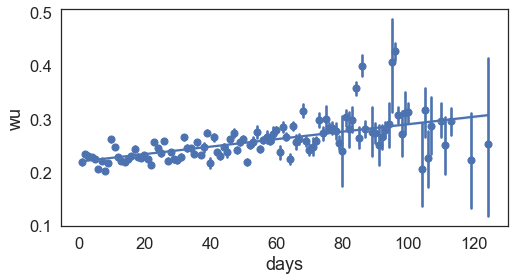

In [515]:
fig, ax = plt.subplots(figsize = (8,4))
sns.regplot(data = day_difference[['days']].join(wu_diff[['wu']]),
                x = 'days', y = 'wu', x_estimator=np.mean)
plt.savefig('figs/wu_days_regplot.pdf', transparent = True, bbox_inches='tight')

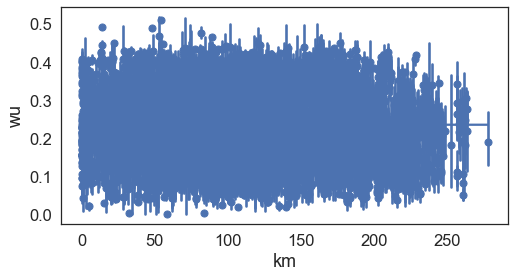

In [522]:
fig, ax = plt.subplots(figsize = (8,4))
sns.regplot(data = geo_difference[['km']].join(wu_diff[['wu']]),
                x = 'km', y = 'wu', x_estimator=np.mean)
plt.savefig('figs/wu_km_regplot.pdf', transparent = True, bbox_inches='tight')

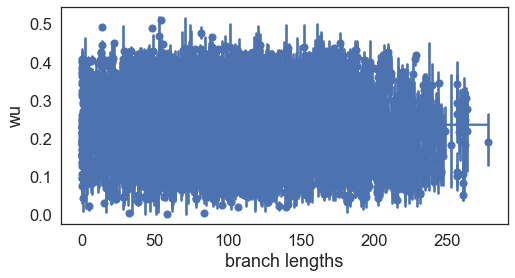

In [523]:
fig, ax = plt.subplots(figsize = (8,4))
sns.regplot(data = phylo_difference[['branch lengths']].join(wu_diff[['wu']]),
                x = 'branch lengths', y = 'wu', x_estimator=np.mean)
plt.savefig('figs/wu_phylo_regplot.pdf', transparent = True, bbox_inches='tight')

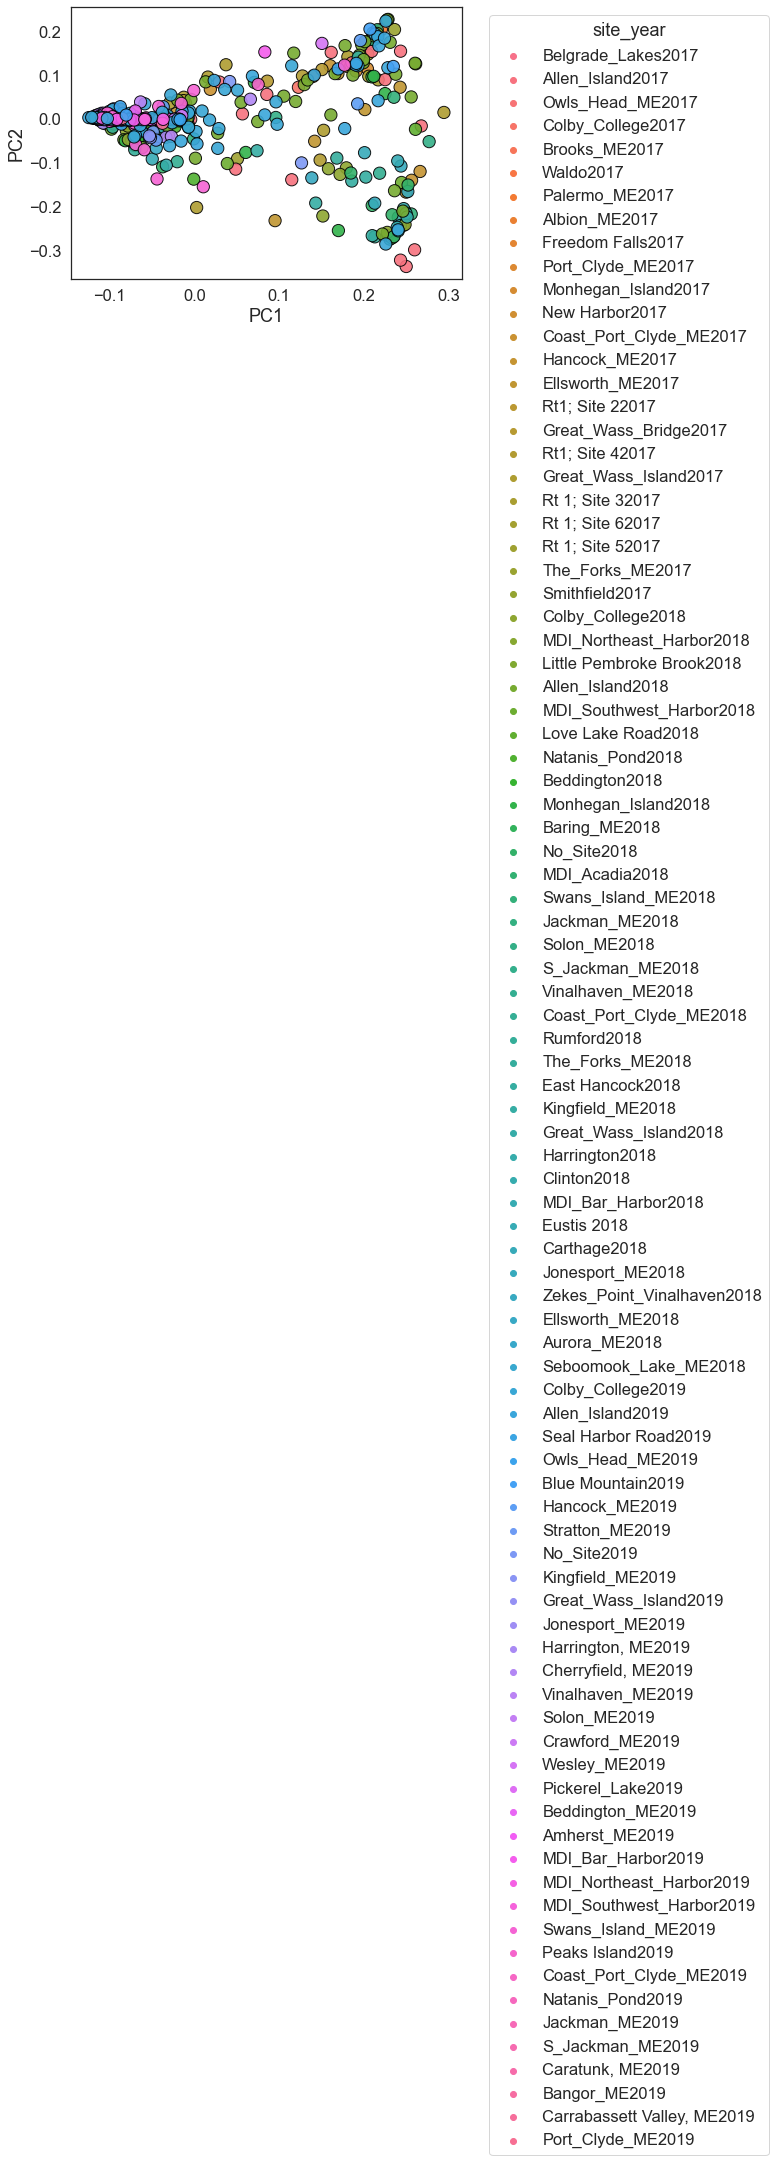

In [473]:
sns.set(style = 'white', font_scale = (1.5))
fig, ax = plt.subplots(1, figsize = (7, 5))

sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            hue = bombusMeta['site_year'],
                s = 150, alpha = 0.9, ax = ax, edgecolor='black')
sns.move_legend(ax, loc = 'upper left', bbox_to_anchor = (1.05,1))

plt.savefig('figs/siteYear_pca.pdf', transparent = True, bbox_inches='tight')

In [457]:
%load_ext rpy2.ipython

In [467]:
bombusMeta['Month'] = bombusMeta['date_of_collection'].apply(lambda x: x.split('/')[0]).apply(lambda x:\
        {'5': 'May', '6': 'June','7': 'July', '8': 'August', '9': 'September'}[x])

In [459]:
bombusMeta['site_trip'] = bombusMeta['site_collapsed'] + bombusMeta['date_of_collection']

In [460]:
bombusMeta['site_year'] = bombusMeta['site_collapsed'] + bombusMeta['Year']

In [461]:
adonisdata = bombusMeta[['species', 'caste', 'site_collapsed', 'Year',
                        'site_trip', 'Month', 'site_year']].dropna().copy()

In [462]:
%%R -i adonisdata,wu_df
library(vegan)

adonis2(wu_df ~ species + caste + site_year + Month, data = adonisdata,
       by = 'margin')

R[write to console]: Loading required package: permute

R[write to console]: Loading required package: lattice

R[write to console]: This is vegan 2.6-2



Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 999

adonis2(formula = wu_df ~ species + caste + site_year + Month, data = adonisdata, by = "margin")
           Df SumOfSqs      R2      F Pr(>F)    
species    10   1.8630 0.07913 6.6381  0.001 ***
caste       2   0.1078 0.00458 1.9210  0.044 *  
site_year  89   4.2785 0.18172 1.7129  0.001 ***
Month       4   0.4305 0.01829 3.8352  0.001 ***
Residual  532  14.9306 0.63416                  
Total     637  23.5439 1.00000                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [132]:
%%R -i adonisdata,wu_df
library(vegan)

adonis2(wu_df ~ species + caste + site_year + Month, data = adonisdata,
       by = 'margin')

Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 999

adonis2(formula = wu_df ~ species + caste + site_year + Month, data = adonisdata, by = "margin")
           Df SumOfSqs      R2      F Pr(>F)    
species    10   1.8630 0.07913 6.6381  0.001 ***
caste       2   0.1078 0.00458 1.9210  0.043 *  
site_year  89   4.2785 0.18172 1.7129  0.001 ***
Month       4   0.4305 0.01829 3.8352  0.001 ***
Residual  532  14.9306 0.63416                  
Total     637  23.5439 1.00000                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Mantel Tests

In [ ]:
from Bio import Phylo
import skbio
from skbio import DistanceMatrix
from math import sin, cos, sqrt, atan2, radians
from qiime2 import Artifact

## make distance matrices

**host**

In [ ]:
'''
Original data from Cameron et al., 2007
Realignment by @aphanotus/borealis/Bombus.tree on github 
'''
tree = Phylo.read(datapath+"/tree", "newick")
# metadata abbrev -> name in tree
lookup = {'imp': 'B._impatiens', 'vag': 'B._vagans', 'bor':'B._borealis', 
                           'bim':'B._bimaculatus', 'san': 'B._sandersoni', 'fer': 'B._fervidus',
                           'ruf': 'B._rufocinctus', 'tern':'B._ternarius', 'per': 'B._perplexus',
                           'terri':'B._terricola', 'gris':'B._griseocollis' }
# make dataframe
dm_host = np.asarray([[tree.distance(lookup[i],lookup[j]) for j in bombusMeta['species']]
                      for i in bombusMeta['species']])
dm_host = pd.DataFrame(dm_host, columns = bombusMeta.index, index = bombusMeta.index)

# save 
dm_host.to_csv((os.path.join(datapath, 'dm/dm_host.csv')))

**geo**

In [ ]:
# haversine formula
R = 6373.0
def getDistance(pos1, pos2): 
    '''
    gets the distance between two coordinate pairs in km
    takes 2 lat lon pairs and returns a float
    '''
    lat1, lon1 = map(radians, pos1)
    lat2, lon2 = map(radians, pos2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

geodif = np.asarray([[getDistance(i,j) for j in bombusMeta[['Latitude', 'Longitude']].to_numpy()]
                         for i in bombusMeta[['Latitude', 'Longitude']].to_numpy()])

geodif = pd.DataFrame(geodif, columns=bombusMeta.index, index = bombusMeta.index)

# save 
geodif.to_csv((os.path.join(datapath, 'dm/geodif.csv')))

**time**

In [ ]:
def getTimeDif(date0, date1):
    d0 = pd.to_datetime(date0)
    d1 = pd.to_datetime(date1)
    delta = d0-d1
    delta = delta.days
    if delta >0:
        return delta
    else:
        return 0-delta

timedif = np.asarray([[getTimeDif(i,j) for j in bombusMeta['date_of_collection'].to_numpy()]
                         for i in bombusMeta['date_of_collection'].to_numpy()])

timedif = pd.DataFrame(timedif, columns=bombusMeta.index, index = bombusMeta.index)
# save 
timedif.to_csv((os.path.join(datapath, 'dm/timedif.csv')))
bombusMeta['date_no_year'] = bombusMeta['date_of_collection'].apply(lambda x: x[:-2]+'23')
timedif_same_summer = np.asarray([[getTimeDif(i,j) for j in bombusMeta['date_no_year'].to_numpy()]
                         for i in bombusMeta['date_no_year'].to_numpy()])

timedif_same_summer = pd.DataFrame(timedif_same_summer, columns=bombusMeta.index, index = bombusMeta.index)

## mantel test

**geo**

In [ ]:
geosamps = bombusMeta[bombusMeta['Longitude'].isna()==False].index
skbio.stats.distance.mantel(geodif.loc[geosamps, geosamps],
                            wu_df.loc[geosamps, geosamps], 'spearman', 999)

**collection date, controlling for same trip**

In [ ]:
bombusMeta['site_trip'] = bombusMeta['collection_site'] + bombusMeta['date_of_collection'] 
bombusMeta['trip_int'] = bombusMeta['site_trip'].replace(dict(zip(bombusMeta['site_trip'].unique(), 
                                 np.arange(len(bombusMeta['site_trip'].unique())))))
ti = bombusMeta['trip_int'].to_numpy()
timedif_same_summer = timedif_same_summer.loc[wu_df.index, wu_df.index]

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -i timedif_same_summer,wu_df,ti
library(vegan)
mantel(timedif_same_summer, wu_df, method='spearman', strata = ti, permutations = 999)

**phylogeny**

In [ ]:
skbio.stats.distance.mantel(dm_host.loc[wu_df.index, wu_df.index],
                            wu_df, 'spearman', 999)